<a href="https://colab.research.google.com/github/quinbez/Vision_Transformer_With_Pytorch/blob/main/Vision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vision Transformer (ViT)**

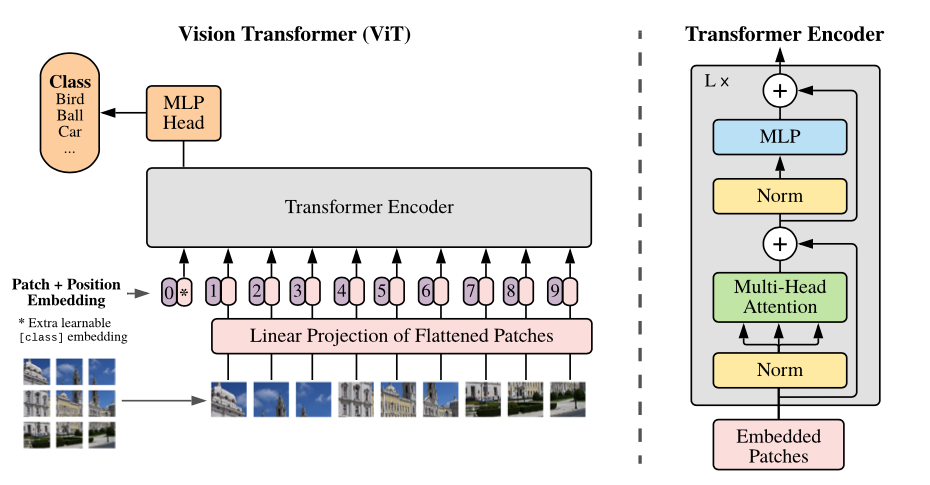

### **DataLoader**

In [ ]:
import os
import numpy as np
import random
import math
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
test_transforms =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.49139968, 0.48215841, 0.44653091], [0.24703223, 0.24348513, 0.26158784])
])

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"

train_dataset = CIFAR10(root = DATASET_PATH, train = True, download = True, transform = train_transforms)
val_dataset = CIFAR10(root = DATASET_PATH, train = True, download = True, transform = test_transforms)

torch.manual_seed(42)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000])

torch.manual_seed(42)
_, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])
test_set = CIFAR10(root = DATASET_PATH, train = False, download = True, transform = test_transforms)

train_loader = data.DataLoader(train_set, batch_size = 128, num_workers = 4, shuffle = True, drop_last = True, pin_memory = True)
val_loader = data.DataLoader(val_set, batch_size = 128, num_workers = 4, shuffle = False, drop_last = False)
test_loader = data.DataLoader(test_set, batch_size = 128, num_workers = 4, shuffle = False, drop_last = False)

100%|██████████| 170498071/170498071 [00:01<00:00, 103688278.55it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Visualizing the image**

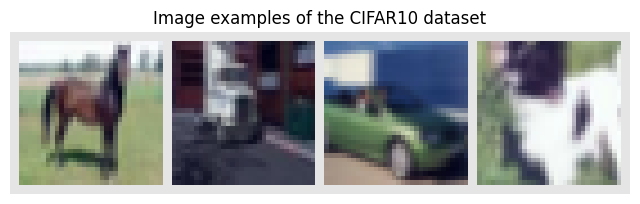

In [ ]:
NUM_IMAGES= 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(CIFAR_images, nrow = 4, normalize = True, pad_value = 0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize = (8, 8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

### **Changing Images into Tokens**

* **
**Input**

The function img_to_patch(x, patch_size, flatten_channels=True) takes an image tensor x, the size of each patch patch_size, and a boolean flatten_channels as input. The purpose of this function is to convert the image tensor into patches with a specified size and flatten the patches into vectors.
* **
**Extracting Dimensions**

B, C, H, W = x.shape extracts the values of the batch dimension (B), number of channels (C), height (H), and width (W) from the shape of the input image tensor x.
* **
**Reshaping and Slicing into Patches**

x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size) reshapes the input tensor x to split it into patches. It uses reshape to rearrange the dimensions, where the height and width are divided by patch_size to determine the number of patches in each dimension. The resulting shape of x becomes `[B, C, H//patch_size, patch_size, W//patch_size, patch_size]`
* **
**Permuting**

x = x.permute(0, 2, 4, 1, 3, 5) permutes the dimensions of x to rearrange them in a desired order. This line is typically used to bring the batch dimension (0) and the channels dimension (1) to the desired positions. The resulting shape of x becomes [B, H', W', C, p_H, p_W], where H' and W' represent the dimensions of the patch grid.
* **
**Flattening Patches**

x = x.flatten(1, 2) flattens the tensor x along dimensions 1 and 2. This operation collapses the dimensions corresponding to the patch grid (H' and W'), resulting in a tensor of shape [B, H'*W', C, p_H, p_W].
* **
**Flattening Channels**

If the flatten_channels flag is True, the following line x = x.flatten(2, 4) flattens the tensor x along dimensions 2 and 4. This operation concatenates the channels (C) and the patch dimensions (p_H and p_W) into a single dimension. The resulting shape of x becomes [B, H'*W', C * p_H * p_W].
* **
**Return**

Finally, the function returns the tensor x, which represents the image divided into patches with the specified patch size. If flatten_channels is True, the patches are flattened into vectors.
* **

In [ ]:
def img_to_patch(x, patch_size, flatten_channels = True):
  B,C,H,W = x.shape
  x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
  x = x.permute(0, 2, 4, 1, 3, 5)
  x = x.flatten(1, 2)       # [B, H*W, C, p_H, p_W]

  if flatten_channels:
    x = x.flatten(2, 4)

  return x

### **Plotting the Patches**

**Generate Patches**

The img_to_patch function is called to convert images from the CIFAR dataset into patches. The patch_size is set to 4, and flatten_channels is set to False, which means each patch will keep its 3-dimensional shape (channels, height, width) instead of being flattened into a 1D vector.

**Prepare the Plot**

A matplotlib subplot is created with the number of rows equal to the first dimension of the CIFAR images tensor (which is likely the batch size or number of images) and one column. The figsize argument sets the width and height of the figure.

**Loop Over Images**

The script loops over each image in the batch (the range is based on the first dimension of the CIFAR images tensor).

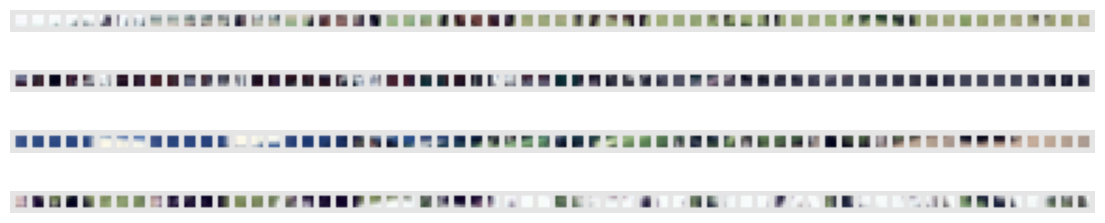

In [ ]:
NUM_IMAGES= 4
CIFAR_images = torch.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_to_patches = img_to_patch(CIFAR_images, patch_size = 4, flatten_channels = False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize = (14, 3))
fig.title = "Image as input sequence of patches"
for i in range(CIFAR_images.shape[0]):
  img_grid = torchvision.utils.make_grid(img_to_patches[i], nrow = 64, normalize = True, pad_value = 0.9)
  img_grid = img_grid.permute(1, 2, 0)
  ax[i].imshow(img_grid)
  ax[i].axis("off")

plt.show()
plt.close()

Compared to the original images, it is much harder to recognize the objects from those patch lists now. This is the input we provide to the Transformer for classifying the images. The model has to learn by itself how it has to combine the patches to recognize the objects.

Now that we have looked at the preprocessing, we can start building the Transformer model. We will be using the PyTorch module, nn.MultiheadAttention. Further, we use the Pre-Layer Normalization version of the Transformer blocks proposed by Ruibin Xiong in 2020. The idea is to apply Layer Normalization not in between residual blocks, but instead as a first layer in the residual blocks. This reorganization of the layers support better gradient flow.

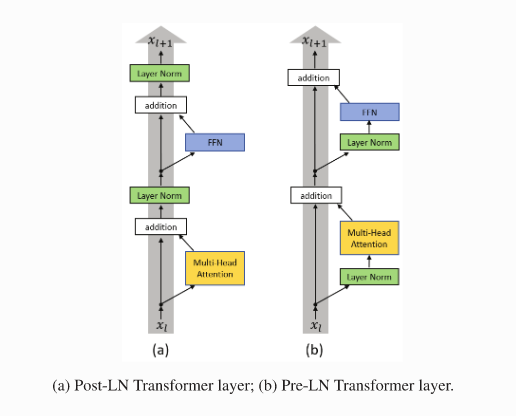

**Post-LN Transformer Layer (a)**

In this configuration, the input first goes through a Multi-Head Attention block, followed by an addition operation with the original input(residual connection), and then it is normalized by a Layer Normalization (LN). Similarly, the output of this LN is passed through a Feed-Forward Network (FFN), followed by another addition with the LN output, and a second LN.

**Pre-LN Transformer Layer (b)**

Here, the input is first normalized and then passed through the Multi-Head Attention block, followed by an addition with the original input. This is then normalized again before going through the FFN and other addition operation with the LN output, without a subsequent normalization.

### **The ViT Architecture**

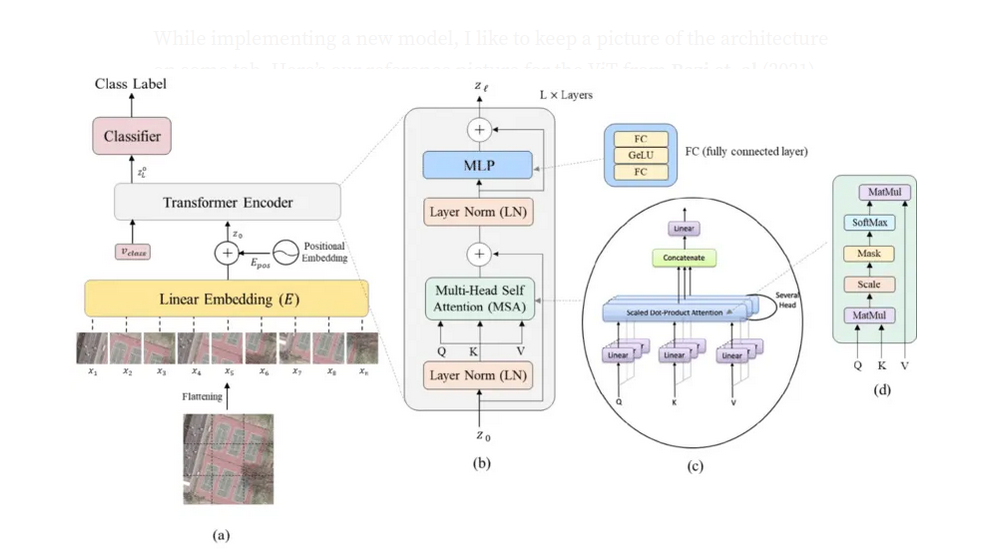

### **The Attention Block**

In [ ]:
class AttentionBlock(nn.Module):
  def __init__(self, embed_dim, hidden_dim, num_heads, dropout  = 0.0):
    super().__init__()
    self.layer_norm_1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout = dropout)
    self.layer_norm_2 = nn.LayerNorm(ember_dim)
    self.linear = nn.Sequential(
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU,
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    inp_x = self.layer_norm_1(x)
    x =  x + self.attn(inp_x, inp_x, inp_x)[0]
    x = x + self.linear(self.layer_norm_2(x))

    return x

### **CLS Token**

The concept of the class token in Vision Transformers (ViT) is borrowed from the BERT model in natural language processing (NLP). In NLP, BERT uses a special [CLS] token that is prepended to the input sequence. Similarly, in ViT, a similar approach is used where a class token is added to the sequence of image patch embeddings.

The purpose of the class token is to aggregate global information from the sequence of embeddings as it passes through the transformer layers. It serves as a representation of the entire image and captures the essential information needed for the final classification decision.

As the class token flows through each transformer layer, it accumulates information from all image patches through the self-attention mechanism. This means that the class token interacts with each patch and attends to relevant features in the image. By doing so, it becomes a distilled representation of the entire image, containing the features necessary for classification.

The specific features captured by the class token are learned during the training process. The transformer architecture enables the class token to learn the most relevant features from the entire image for the given task, whether it involves recognizing objects, scenes, or other visual patterns.

**Dimension of CLS Token**

The class token in Vision Transformers (ViT) is typically initialized with a shape of (1, 1, embed_dim), where:

* The first '1' indicates a single class token.
* The second '1' indicates that there is one class token per sequence or per image.
* 'embed_dim' represents the size of the embedding vector, which matches the dimensionality of the patch embeddings.

For example, if the dimension of the image is `[B, H'*W', C*p_H*p_W]`, where B is the batch size, H' and W' are the height and width of the image grid, C is the number of channels, and p_H and p_W are the height and width of each patch, then the **shape of the tokens tensor** would be `[B, num_patch, patch_size_vector], such as [B, 49, 8]`.

To add the class token to each sequence in the batch, the class token's embedding must be replicated 'B' times. Therefore, the **initial dimensions of the class token** would be `(1, 1, embed_dim)` or `(1, 1, 8)` in the given example.

To concatenate the class token with the tokens tensor, the class token is expanded to match the batch size 'B'. The expanded dimensions for the class token would be `(B, 1, embed_dim)` or `(B, 1, 8)`.

When the class token is concatenated with the tokens tensor, the resulting tensor would have the shape `(B, 50, embed_dim)` or `(B, 50, 8)`. This shape represents the batch size 'B', the total number of items in the sequence `(49 patches + 1 class token)`, and the embedding dimension.

After propagating through the transformer encoder, the final state of the class token, which is still (B, 1, embed_dim), is used by the classifier head (often an MLP) to make the final classification decision. The classifier head takes the information captured by the class token and processes it to produce the desired classification output.


**Concatinating CLS Token**

`cls_token = self.cls_token.repeat(B, 1, 1)`

 The class token, which is a learnable parameter initialized in the model, is repeated 'B' times to match the batch size. This way, each item in the batch has its own copy of the class token.

`x = torch.cat([cls_token, x], dim=1)`

 The class token is concatenated with the input sequence of patches, 'x'. By adding the class token at the beginning of the sequence, we include global information about the image in the input. This helps the model capture context and make better predictions.



### **Positional Embedding**

In the vision transformer and other transformer based models, positional embeddings are used to provide the model with information about the order or position of the input tokens because transformers by their nature do not have any inherent notion of sequence order.

Positional Embedding is a vector added to the input embeddings to encode the position of each token in the sequence. In the case of images, each patch is a token, and its position with in the original image is important for the model to understand the spatial relationships between patches.

**Shape of Positional Embedding**

When initialized the positional embedding has a shape of (1, 1+num_patches, embed_dim)

* nn.parameter: This makes "pos_embedding", a learnable parameter, which means it's values will be optimized during the training process.

* The first dimension '1' indicates that a single set of positional embeddings is used for the whole batch. This is because the positional relationships are the same for every instance in the batch

* '1+num_patches' :- is the length of the sequence that will be input into the transformer, which includes the class token ('1') plus all the image patches ('num_patches'). Therefore, every position in the sequence, including the class token, gets a unique positional embedding.

* 'embed_dim' :- is the size of the embedding vector, which matches the size of the embeddings for each patch and the class token.

After initialization, the shape of 'pos_embedding' is `(1, 1+num_patches, embed_dim)`. When used in a forward pass with a batch of data, it will be expanded to match the batch size, resulting in a tensor shape (batch_size, 1+num_patches, embed_dim).

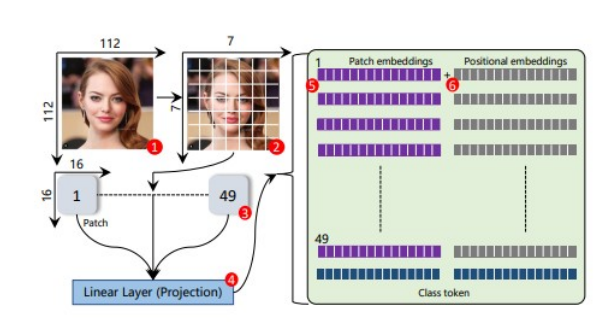

**Adding Positional Embedding**

`x = x + self.pos_embedding[:,:T+1]`

 The positional embeddings are added to the token embeddings. Positional embeddings encode information about the position of each token in the sequence. The slicing [:,:T+1] ensures that the positional embeddings align with the number of tokens in the sequence, including the class token. This step helps the model understand the spatial relationships between different patches in the image.

### **Applying Transformer**


`x = self.dropout(x)`

Dropout is a technique used to prevent overfitting in neural networks. In this case, it is applied to the input sequence, 'x'. Dropout randomly sets a fraction of the elements in 'x' to zero during training. By doing so, it helps the model become more robust and less dependent on specific elements in the input sequence.

`x = x.transpose(0, 1)`

The dimensions of the input sequence, 'x', are swapped. The original shape of 'x' is (sequence length, batch size, embedding dimension). However, the transformer expects the sequence length to be the first dimension. Therefore, the transpose operation swaps the batch size and sequence length dimensions, making the shape of 'x' (batch size, sequence length, embedding dimension) to match the transformer's input expectation.

`x = self.transformer(x)`

The transformed input sequence, 'x', is passed through the transformer encoder. The transformer encoder consists of multiple layers, typically containing self-attention mechanisms. Self-attention allows each token in the sequence to interact with every other token, capturing dependencies and relationships between them. This interaction helps the model understand the context and relationships within the input sequence, enabling it to extract relevant features and make informed predictions.

### **Classification Prediction**

`cls = x[0]`

After the sequence passes through the transformer encoder, the first token of the transformed sequence, denoted as x[0], is assumed to correspond to the class token. In the previous steps, we concatenated the class token at the beginning of the sequence, so it carries aggregated information about the entire image. By selecting x[0], we isolate the class token from the rest of the tokens in the sequence.

`out = self.mlp_head(cls)`

The isolated class token, denoted as cls, is then passed through a multilayer perceptron (MLP) head. An MLP is a type of neural network that consists of multiple layers of interconnected nodes (neurons). The MLP head processes the information contained in the class token and performs further transformations and computations to make the final classification prediction.

### **Output of ViT**

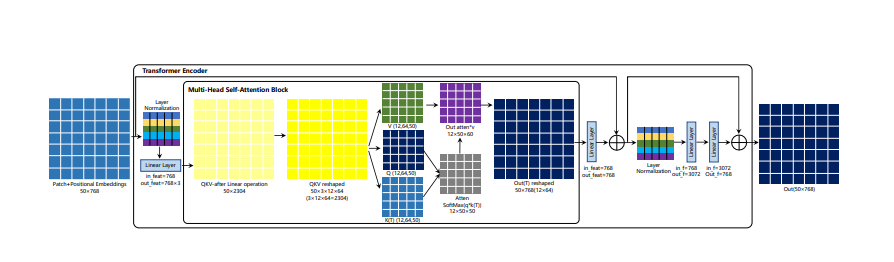

The output of the transformer encoder is a sequence of embeddings that corresponds to the input sequence. This sequence includes the CLS token followed by the embeddings of the image patches. Each embedding in the sequence has been updated by the transformer encoder through its self-attention and feed-forward layers.

If the input sequence to the transformer has a shape of (N, T+1, embed_dim), where N is the batch size, T+1 is the number of tokens (including the CLS token), and embed_dim is the embedding dimension, then the output will have the same shape.

The CLS token is typically the first token in the sequence. After the sequence has been processed by the transformer, the state of the CLS token is at the first position of the sequence for each image in the batch.

The code snippet `cls = x[0]` extracts the first token from the sequence, which corresponds to the transformed state of the CLS token. Here, x[0] takes the first element along the sequence dimension (not the batch dimension). The result is a tensor containing the CLS tokens for each item in the batch.

The shape of cls after this operation will be (embed_dim, B), where B is the batch size and embed_dim is the embedding dimension. This means that for each image in the batch, we have the transformed state of the CLS token, which contains aggregated information relevant for classification.

While the CLS token is typically used for classification tasks, the transformed patch embeddings can be used for other purposes depending on the specific application. For example, in tasks like object detection or image segmentation, these patch embeddings can be further processed to determine the location and identity of objects within the image.

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, embed_dim, hidden_dim, num_channels, num_heads,num_layers, num_classes, patch_size, num_patches, dropout = 0.0):
    super().__init__()
    self.patch_size = patch_size
    self.input_layer = nn.Linear(num_channels*(patch_size**2), embed_dim)
    self.transformer = nn.Sequential(
        *[AttentionBlock(embed_dim, hidden_dim, num_heads, dropout=dropout) for _ in range(num_layers)]
    )
    self.mlp_head = nn.Sequential(
        self.LayerNorm(embed_dim),
        self.Linear(embed_dim, num_classes)
    )
    self.dropout = nn.Dropout(dropout)
    self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
    self.pos_embedding = nn.Parameter(torch.randn(1, 1+num_patches, embed_dim))

  def forward(self, x):
    x = img_to_patches(x, self.patch_size)
    B, T, _ = x.shape
    x = self.input_layer(x)

    cls_token = self.cls_token.repeat(B, 1, 1)
    x = torch.cat([cls_token, x], dim = 1)
    x = x + self.pos_embedding[:,:T+1]

    x = self.dropout(x)
    x = x.transpose(0, 1)
    x = self.transformer(x)

    cls = x[0]
    out = self.mlp_head(cls)
    return out